In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

from models import Encoder, Decoder, AutoEncoder, AngleDistanceLoss

## Generate synthetic data

In [15]:
def gen_data(N_pixels, B, R, plot=False, noise_level=1e-3):
    abundances = nn.functional.normalize(nn.functional.relu(1 + 0.5*torch.randn((N_pixels, R))))
    endmembers = np.zeros((R, B))

    for r in range(R):
        # Generate a gaussian endmember
        mu = np.random.random() * B
        sigma_2 = np.exp(-np.random.random()*3)*B
        endmembers[r] = np.exp(-(np.arange(B)-mu)**2/2/sigma_2)

    endmembers = torch.tensor(endmembers, dtype=torch.float)

    noise = torch.randn(N_pixels, B) * noise_level
    data = abundances @ endmembers + noise

    if plot:
        plt.imshow(endmembers.detach().numpy(), vmin=0)
        plt.title("True endmembers")
        plt.show()
        plt.imshow(abundances.detach().numpy(), vmin=0)
        plt.title("True abundances")
        plt.show()
        plt.imshow(data.detach().numpy(), vmin=0)
        plt.title("True data")
        plt.show()

    return abundances, endmembers, data

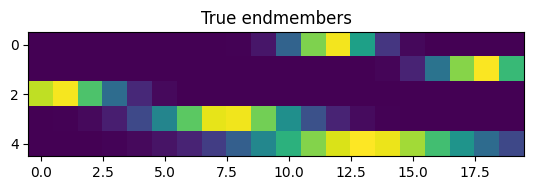

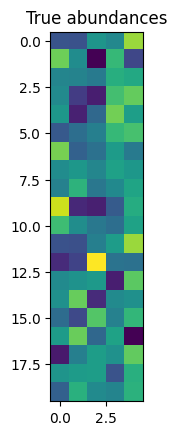

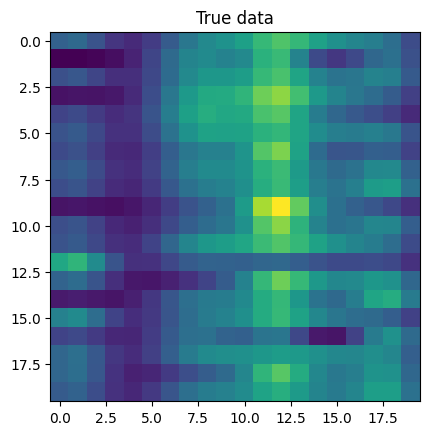

In [20]:
B = 20 # Number of spectral bands
R = 5 # Number of endmembers

N_pixels = 20
torch.manual_seed(0)
np.random.seed(20)
abundances_small, endmembers_small, data_small = gen_data(N_pixels, B, R, plot=True)

N_pixels = 10000
torch.manual_seed(0)
np.random.seed(20)
abundances, endmembers, data = gen_data(N_pixels, B, R, plot=False)

### Comparison of the MSE and SAD losses

In [9]:
def unmix_synthetic_data(data, loss_function, epochs=500, lr=1e-2, betas=(0.9, 0.99), 
                         plot=False, plot_endmembers_only=False):
    encoder = Encoder(B=B, R=R)
    decoder = Decoder(B=B, R=R)
    ae = AutoEncoder(encoder, decoder)

    opti = torch.optim.Adam(ae.parameters(), lr=lr, betas=betas)

    losses = []

    # Training loop
    for e in tqdm(range(epochs)):
        opti.zero_grad()
        embeddings, reconstruct = ae(data)
        loss = loss_function(reconstruct, data)
        loss.backward()
        opti.step()
        ae.projection()

        losses.append(loss.detach().numpy())

    # Final evaluation
    with torch.no_grad():
        embeddings, reconstruct = ae(data)
        loss = loss_function(reconstruct, data)

    est_endmembers = decoder.W.detach().numpy()
    est_abundances = embeddings.detach().numpy()
    reconstruct = reconstruct.detach().numpy()
    
    if plot:
        print("Final loss", loss.numpy())
        if not plot_endmembers_only:
            plt.plot(losses)
            plt.title("Loss")
            plt.show()

        plt.imshow(est_endmembers, vmin=0)
        plt.title("Estimated endmembers")
        plt.show()

        if not plot_endmembers_only:
            plt.imshow(est_abundances, vmin=0)
            plt.title("Estimated abundances")
            plt.show()
            plt.imshow(reconstruct, vmin=0)
            plt.title("Reconstruction")
            plt.show()

    return est_endmembers, est_abundances, reconstruct, losses

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:02<00:00, 185.99it/s]


Final loss 0.0016794583


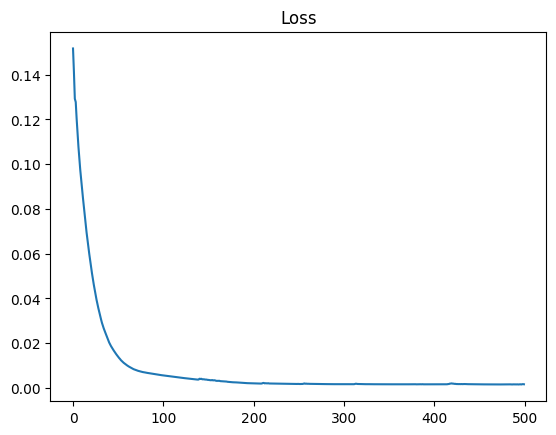

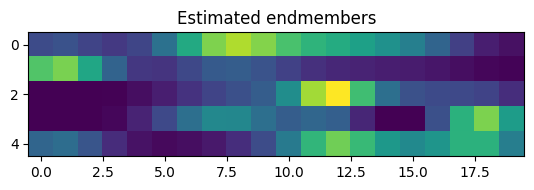

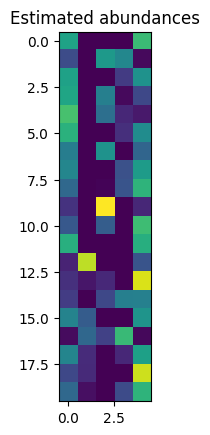

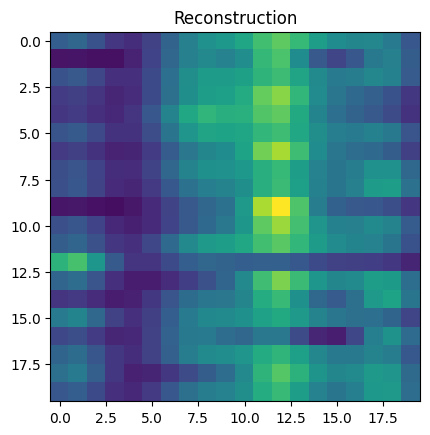

100%|██████████| 500/500 [00:11<00:00, 43.40it/s]


Final loss 0.0008078726


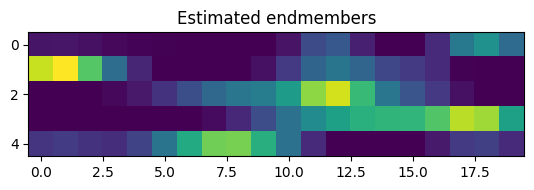

In [21]:
ret_small_mse = unmix_synthetic_data(data_small, nn.MSELoss(), plot=True)
ret_mse = unmix_synthetic_data(data, nn.MSELoss(), plot=True, plot_endmembers_only=True)

100%|██████████| 500/500 [00:02<00:00, 249.37it/s]

Final loss 0.038471814


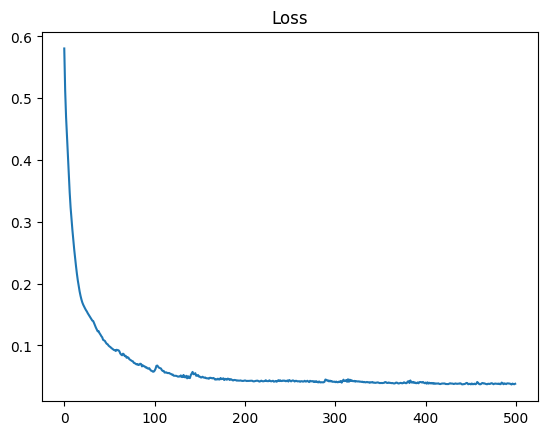

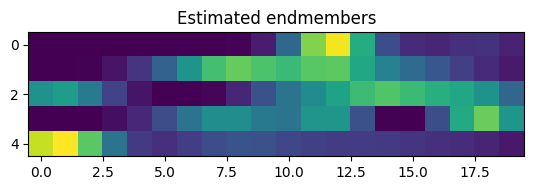

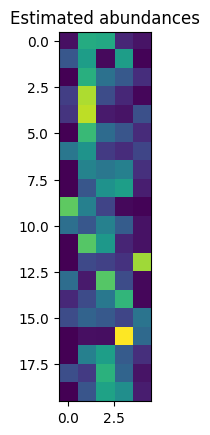

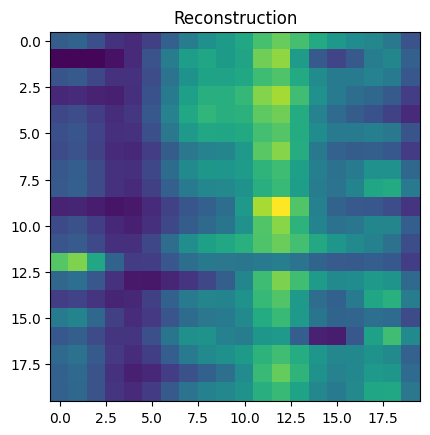

100%|██████████| 500/500 [00:13<00:00, 38.38it/s]


Final loss 0.0085092755


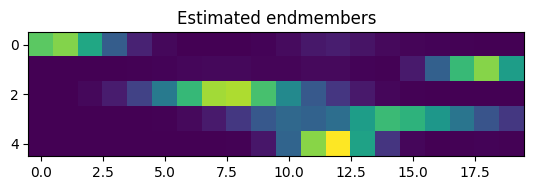

In [22]:
ret_small_sad = unmix_synthetic_data(data_small, AngleDistanceLoss(), plot=True)
ret_sad = unmix_synthetic_data(data, AngleDistanceLoss(), plot=True, plot_endmembers_only=True)

## Real data

In [16]:
def MULecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1,A = -1, S = -1, frozenA=False):
    '''
    Inputs: 
    %           X: is a [mxn] matrix to unmig
    %
    %           r: size of the matrices A and S
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           A: is a [m x n] matrix 
    %           
    %           S: is a [n x t] matrix c
    %
  '''
    if r is None:
        r=X.shape[0]
    
    if frozenA:
        r = A.shape[1]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    if np.any(A < 0) and (not frozenA):
        A=np.random.random((d, r))
    if np.any(S < 0):
        S=np.random.random((r, N)) 
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # Multiplicative method      
        
        if not frozenA:
            A = A * (X @ S.T) / (A @ S @ S.T + eps) # Add a +eps in the denominator to avoid division by 0
        
        S = S * (A.T @ X) / (A.T @ A @ S + eps) # Add a +eps in the denominator to avoid division by 0

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(A,S)     

        delta = np.linalg.norm(diff,'fro') / np.linalg.norm(X,'fro') 
        evolutionDelta.append(delta)
        
        if plot_evolution and (k==1 or k%100==0):
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', np.linalg.norm(diff))
     
    
    if plot_evolution==1:
        if k==N_Iter:
            print('Maximum number of iterations reached ! delta = ', delta)
        else:
            print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return A,S

In [17]:
def FCLS(pixels, endmembers): # Fully constrined least square (ref 44 of article)
    """
    Find abundances from the VCA endmemmbers

    pixels: (n_pixels, B)
    endmembers: (R, B)

    TODO: implement FCLS (now it is a basic linear regression)

    D. C. Heinz and C.-I. Chang, “Fully constrained least squares linear
    spectral mixture analysis method for material quantification in hyper-
    spectral imagery,” IEEE Trans. Geosci. Remote Sens., vol. 39, no. 3,
    pp. 529-545, Mar. 2001.
    """
    return torch.inverse(endmembers @ endmembers.T) @ endmembers @ pixels.T


In [18]:
def simpleVCA(X,r,optDisp=False):

    R = X.copy()
    
    
    K = np.zeros(r)
    
    for ii in range(r):
        c = np.random.rand(X.shape[0])
        ctX = c.T @ R
        
        p = np.argmax(ctX)
        K[ii] = p
        Rp = np.expand_dims(R[:,p],axis=1)
        
        if optDisp == True:
            fig = plt.figure()
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(R[0,:],R[1,:],R[2,:])
        
        R = R - (Rp@Rp.T /(np.sum(Rp.squeeze()**2)))@R
        
    print('Max residual %s'%np.max(R))
    
    return K.astype(int)

Max residual 0.1772317054094291


Text(0.5, 1.0, 'Estimation by VCA')

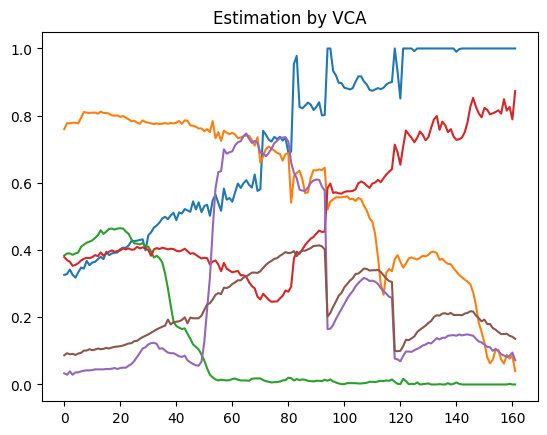

In [19]:
K_VCA = simpleVCA(X,6)

VCA_endmembers = X[:,K_VCA]

plt.figure(),plt.plot(VCA_endmembers)
plt.title('Estimation by VCA')

In [20]:
X.shape, VCA_endmembers.shape

((162, 94249), (162, 6))

kmeans clustering

In [21]:
X

array([[0.109, 0.116, 0.119, ..., 0.016, 0.012, 0.009],
       [0.113, 0.119, 0.119, ..., 0.019, 0.016, 0.013],
       [0.118, 0.13 , 0.127, ..., 0.028, 0.025, 0.023],
       ...,
       [0.259, 0.266, 0.289, ..., 0.077, 0.062, 0.047],
       [0.237, 0.256, 0.275, ..., 0.076, 0.066, 0.057],
       [0.264, 0.307, 0.275, ..., 0.061, 0.05 , 0.072]])

In [22]:
from sklearn.cluster import KMeans

K = 200
kmeans = KMeans(n_clusters=K, n_init=3)

kmeans.fit(X[:, ::5].T)


KMeans(n_clusters=200, n_init=3)

In [23]:
superpixels_indices = kmeans.predict(X.T)
print(superpixels_indices.shape)

(94249,)


In [24]:
batches = []
batch_size = 32


for k in range(K):
    pixel_indices = np.nonzero(superpixels_indices==k)[0]

    if pixel_indices.size >= 32:
        subsample = np.random.choice(pixel_indices.size, size=batch_size, replace=False)

        batches.append(torch.tensor(X[:, pixel_indices[subsample]].T, dtype=torch.float))

In [25]:
means = []
sqrt_covariances = []
eps = 1e-5
nb_none = 0

VCA_endmembers = torch.tensor(VCA_endmembers, requires_grad=False, dtype=torch.float)
for batch in tqdm(batches):
    #abundances = FCLS(batch, VCA_endmembers.T).T
    abundances = MULecture(batch.detach().numpy().T, A=VCA_endmembers.detach().numpy(), frozenA=True, plot_evolution=False)[1]
    abundances = torch.tensor(abundances, dtype=torch.float)
    mean = abundances.mean(axis=1)
    means.append(mean)

    centered_abundances = (abundances.T - mean).T
    cov = centered_abundances @ centered_abundances.T
    sqrt = torch.linalg.cholesky(cov + torch.eye(len(mean))*eps).T

    sqrt_covariances.append(sqrt)


100%|██████████| 196/196 [00:19<00:00,  9.83it/s]


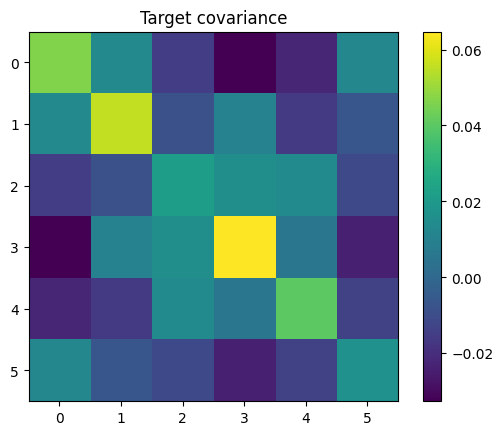

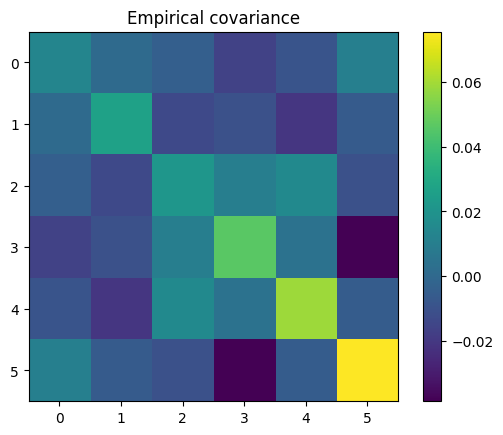

In [26]:
sqrt = sqrt_covariances[np.random.randint(0, len(sqrt_covariances))]
plt.imshow((sqrt @ sqrt.T).detach().numpy())
plt.title("Target covariance")
plt.colorbar()
plt.show()

noise = np.random.randn(1000, 6)
samples = noise @ sqrt.detach().numpy()
empirical_cov = (samples.T @ samples)/1000
plt.imshow(empirical_cov)
plt.title("Empirical covariance")
plt.colorbar()
plt.show()

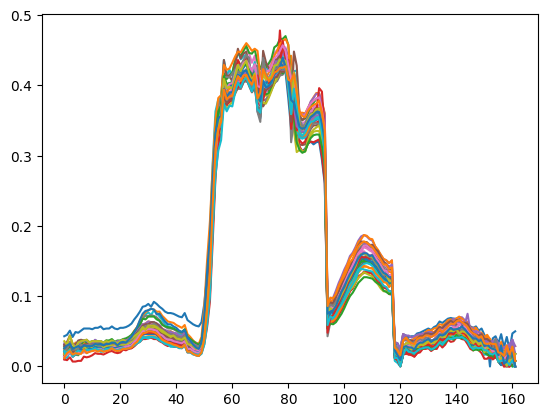

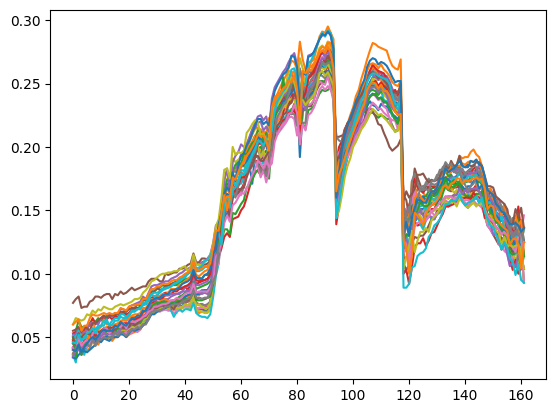

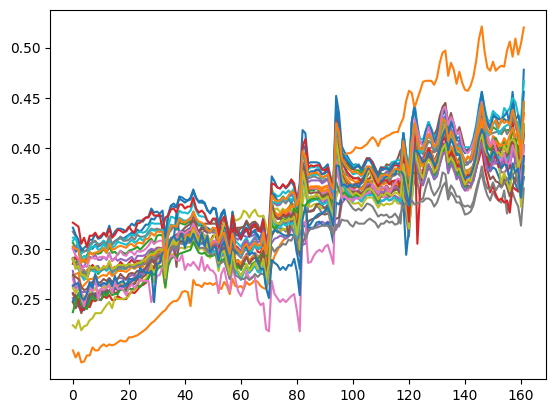

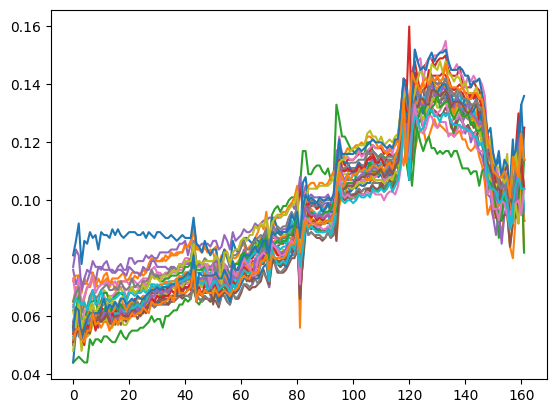

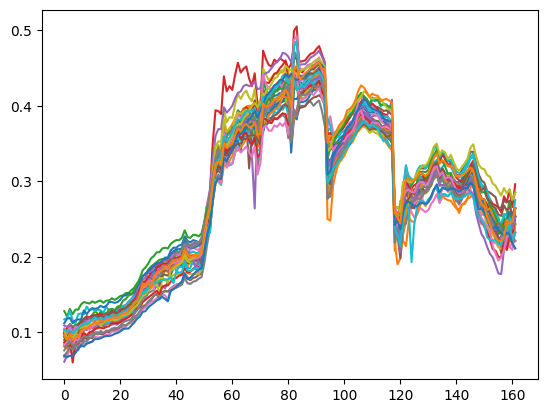

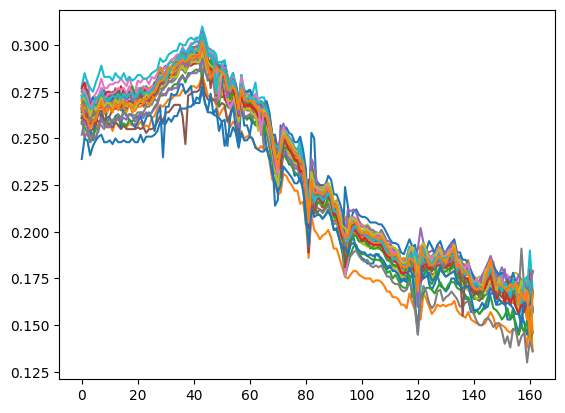

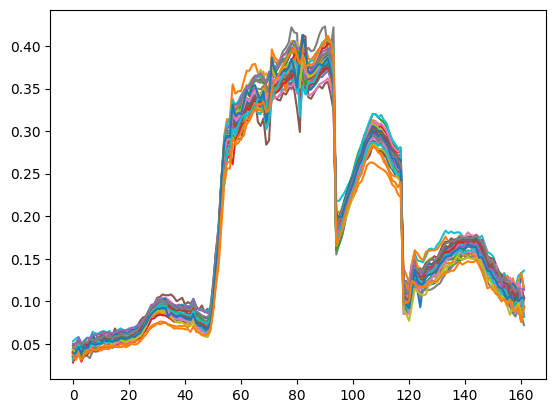

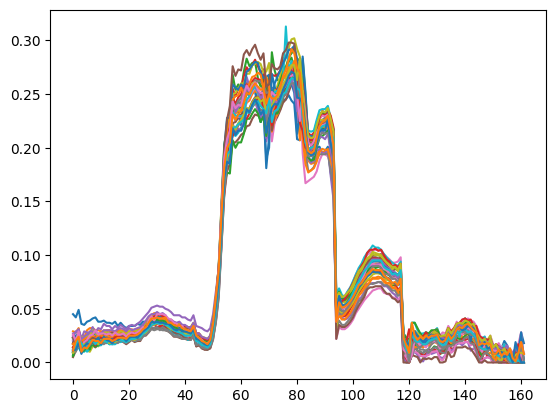

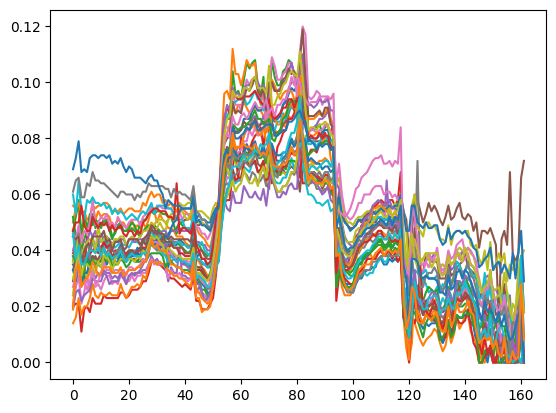

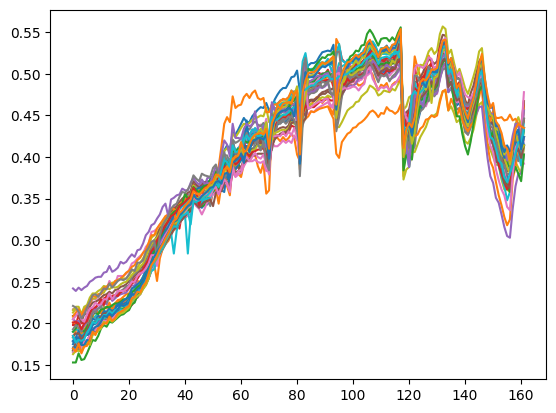

In [27]:
for i in range(10):
    plt.plot(batches[i].detach().numpy().T)
    plt.show()

## Train the AAENet without adversarial regularization

### Random decoder initialization

In [ ]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R)
ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.5, 0.9))

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])[1]
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

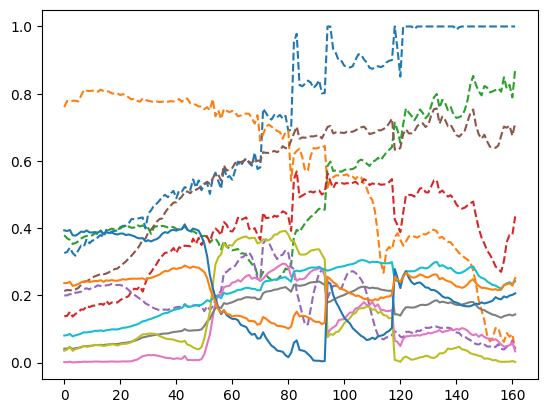

In [161]:
plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
#plt.legend()
plt.show()

### Using VCA as initialization for decoder

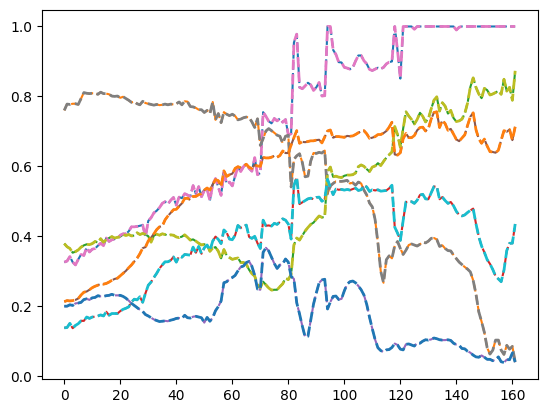

100%|██████████| 20/20 [00:11<00:00,  1.67it/s]

Final loss 0.41298229


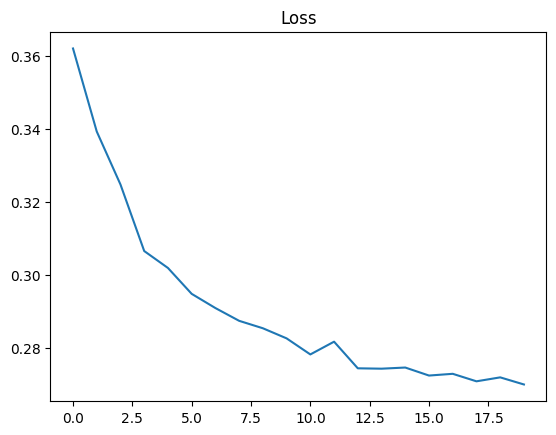

In [162]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(encoder.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 20
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])[1]
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b]) 
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(np.array(losses))
#plt.yscale('log')
plt.title("Loss")
plt.show()

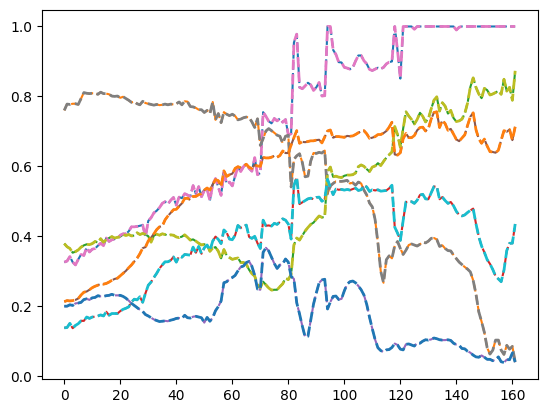

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]

Final loss 0.11771018


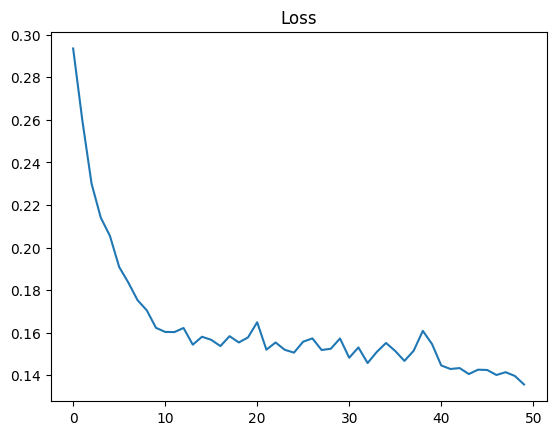

In [163]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])[1]
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(np.array(losses))
#plt.yscale('log')
plt.title("Loss")
plt.show()

In [164]:
np.array(losses).dtype

dtype('float64')

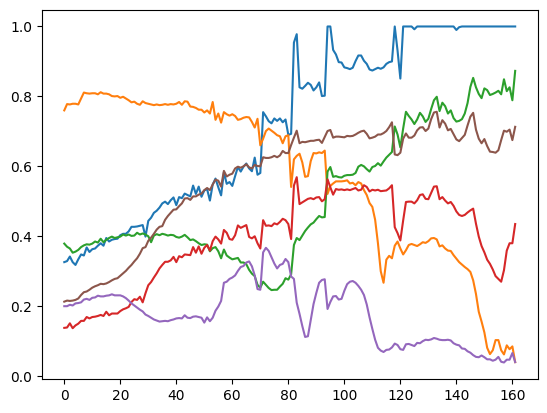

In [165]:

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers")
plt.show()

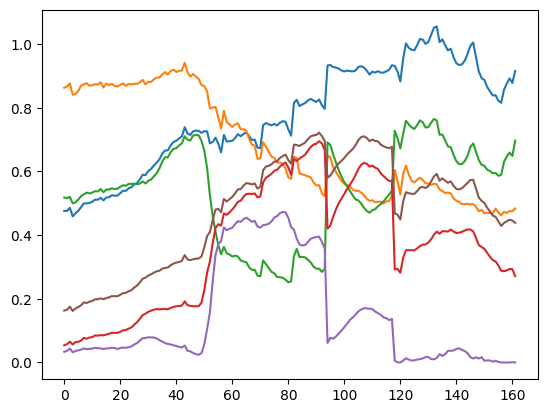

In [166]:
#plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.show()

### Initialize with VCA and freeze decoder

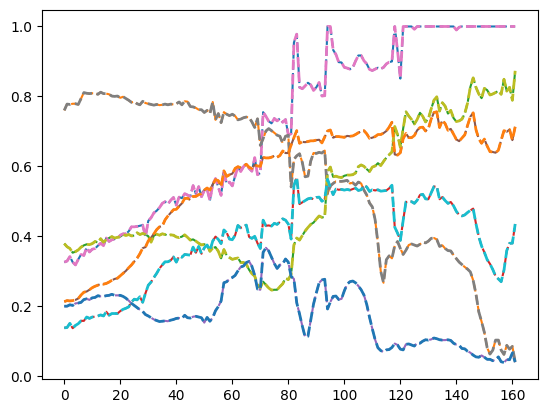

100%|██████████| 50/50 [00:29<00:00,  1.71it/s]

Final loss 0.41652897


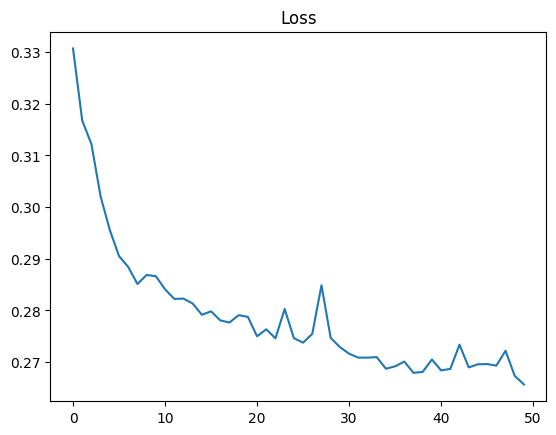

In [167]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]


encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T, freeze=True)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.show()

epochs = 50
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()
        reconstruct = ae(batches[b])[1]
        #reconstruct = decoder(abundances)
        loss = sad(reconstruct, batches[b])
        loss.backward()
        opti.step()
        ae.projection()
        opti.zero_grad()
        loss_epoch += loss.detach().numpy()

    losses.append(loss_epoch / len(batches))
    #print("Decoder variation", np.linalg.norm(decoder.W.detach().numpy() - VCA_endmembers.T))

print("Final loss", loss.detach().numpy())
plt.plot(losses)
#plt.yscale('log')
plt.title("Loss")
plt.show()

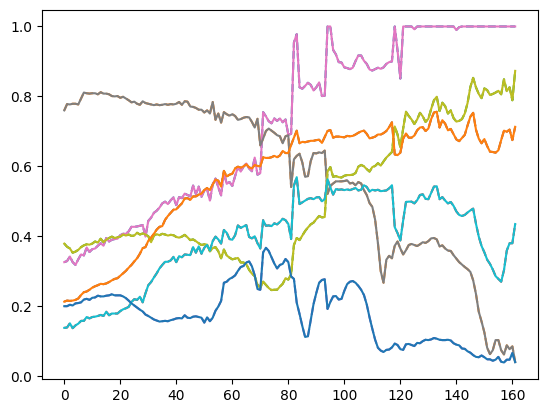

In [168]:
plt.plot(VCA_endmembers.detach().numpy(), label="VCA endmembers", linestyle='--')
plt.plot(decoder.W.detach().numpy().T, label="Endmembers of the decoder")
plt.show()

### Add the regularization term on the decoder

In [137]:
def train_autoencoder(ae, batches, epochs, lamb):
        
    sad = AngleDistanceLoss()
    opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))


    mse_vca = []
    losses_vca = []
    losses_rec = []
    losses = []

    for e in tqdm(range(epochs)):
        loss_epoch = 0
        loss_vca_epoch = 0
        loss_rec_epoch = 0
        for b in range(len(batches)):
            opti.zero_grad()

            # Regularization w.r.t VCA endmembers
            loss_vca = sad(ae.decoder.W, VCA_endmembers.T)
            loss_vca_epoch += loss_vca.detach().cpu().numpy()
            loss_vca = lamb * loss_vca
            loss_vca.backward()
            ae.decoder.W.grad[ae.decoder.W.grad.isnan()] = 0
            
            # Train the reconstruction
            reconstruct = ae(batches[b])[1]
            loss_rec = sad(reconstruct, batches[b]) 
            loss_rec_epoch += loss_rec.detach().cpu().numpy()
            loss_rec.backward()
            
            opti.step()
            ae.projection()

            loss = loss_rec.detach().cpu().numpy() + loss_vca.detach().cpu().numpy()
            loss_epoch += loss
            
        losses_vca.append(loss_vca_epoch / len(batches))
        losses_rec.append(loss_rec_epoch / len(batches))
        losses.append(loss_epoch / len(batches))
        mse_vca.append(np.linalg.norm(ae.decoder.W.detach() - VCA_endmembers.T))

    print("VCA loss:", losses_vca[-1])
    print("Reconstruction loss:", losses_rec[-1])
    print("Total loss:", losses[-1])
    #plt.plot(mse_vca, label="MSE VCA", color="blue", linestyle='--')
    plt.plot(losses_vca, label="Endmembers loss", color="blue")
    plt.plot(losses_rec, label="Reconstruction loss", color="green")
    plt.plot(losses, label="Total loss", color="red")
    plt.legend()
    plt.xlabel("Epochs")
    plt.title("Autoencoder loss, $\lambda$="+str(lamb))
    plt.show()

    ref_endmembers = VCA_endmembers.detach().numpy()
    dec_endmembers = ae.decoder.W.detach().numpy().T

    for i in range(R):
        plt.plot(ref_endmembers[:,i], color=plt.cm.tab10(i), linewidth=0.9)
        plt.plot(dec_endmembers[:,i], color=plt.cm.tab10(i), linestyle="--")
    plt.title("VCA (solid lines) vs decoder (dashed lines), $\lambda$="+str(lamb))
    plt.show()


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


VCA loss: 0.006852380080832814
Reconstruction loss: 0.20672787733528078
Total loss: 0.21358025746838172


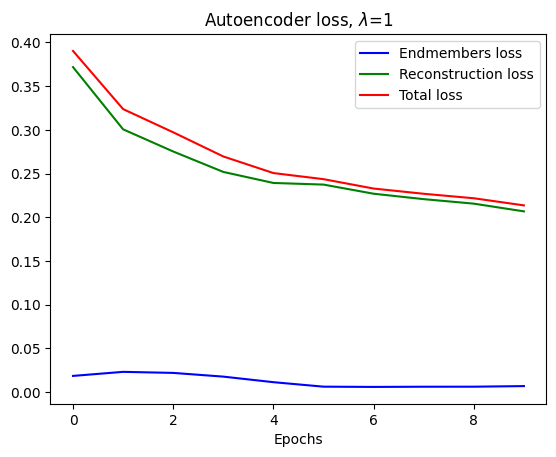

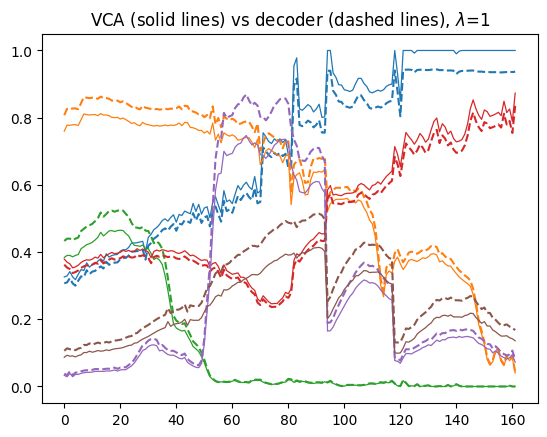

In [140]:
lamb = 1
epochs = 10

encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T, freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, batches, epochs, lamb)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


VCA loss: 0.10971139603275426
Reconstruction loss: 0.16800366482716433
Total loss: 0.17897480441143318


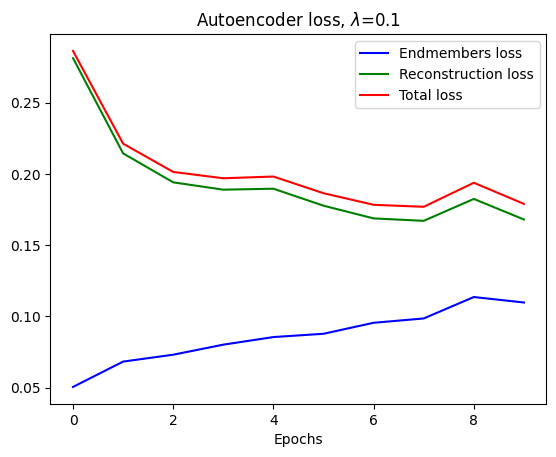

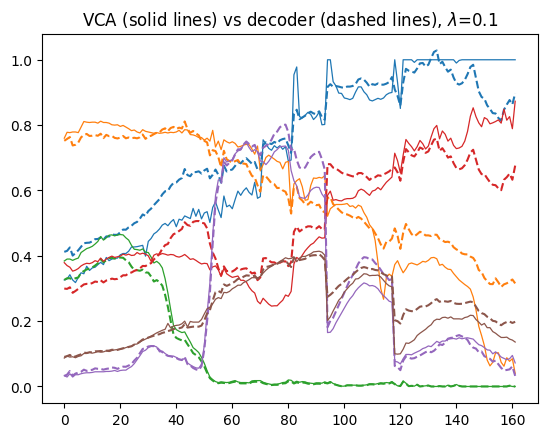

In [138]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]

lamb = 0.1
epochs = 10

encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T, freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, batches, epochs, lamb)

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


VCA loss: 0.23969555159612577
Reconstruction loss: 0.18082863421236373
Total loss: 0.18322558896806168


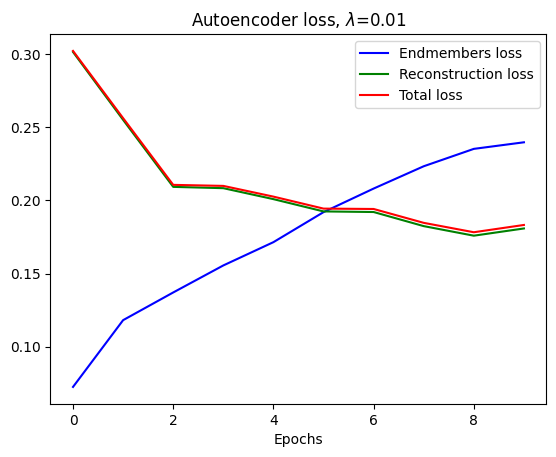

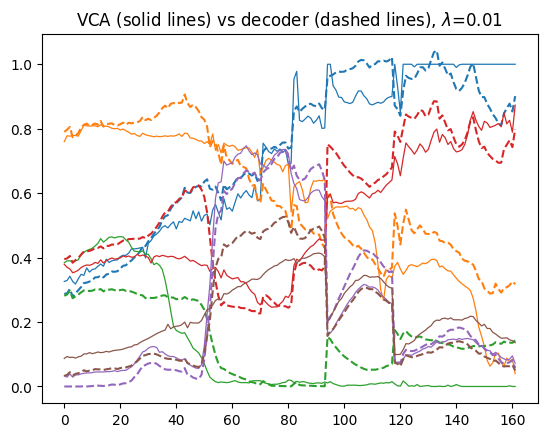

In [139]:

lamb = 0.01
epochs = 10

encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T, freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, batches, epochs, lamb)

100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


VCA loss: 0.2389420681461996
Reconstruction loss: 0.1668687077543261
Total loss: 0.1668687077543261


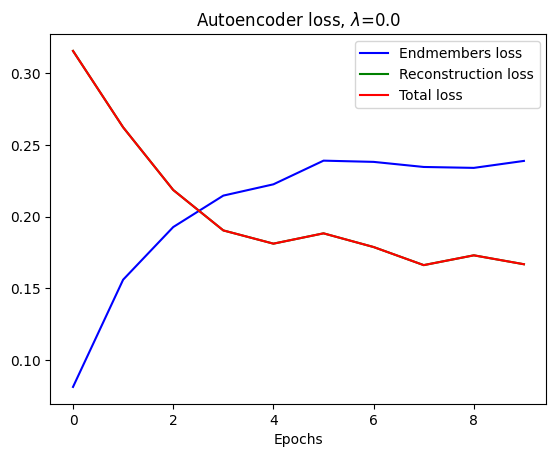

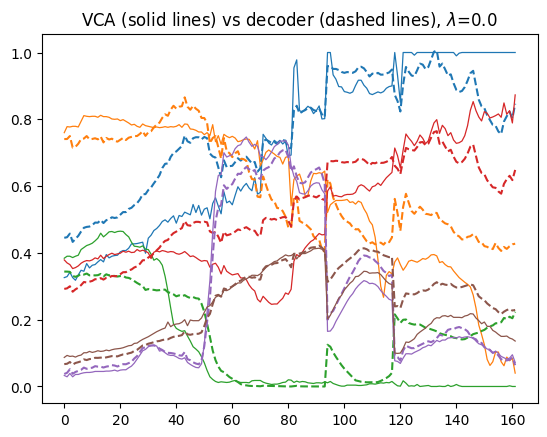

In [141]:

lamb = 0.0
epochs = 10

encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T, freeze=False)
ae = AutoEncoder(encoder, decoder)

train_autoencoder(ae, batches, epochs, lamb)

#### old


In [28]:
batches[0].shape, VCA_endmembers.shape, decoder.W.shape

(torch.Size([32, 162]), torch.Size([162, 6]), torch.Size([5, 20]))

In [37]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]

In [86]:
encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T + torch.randn(R, B)*1e-3)

ae = AutoEncoder(encoder, decoder)

sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

opti.zero_grad()

loss = sad(ae.decoder.W.T, VCA_endmembers)

print(loss)

loss.backward()

opti.step()

print(torch.any(decoder.W.grad.isnan()))

decoder.W.grad

tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(False)


tensor([[-3.6370e-03, -2.4490e-03,  1.7040e-03,  6.3324e-04,  2.1899e-03,
         -2.6052e-03,  2.6886e-03,  2.6276e-03,  1.2209e-03, -2.0536e-03,
         -1.7723e-03,  9.3877e-04, -2.8411e-03,  1.4320e-03, -4.8629e-03,
         -3.4010e-04, -1.1871e-03,  2.5365e-03,  2.6238e-04,  5.5766e-04,
         -1.2183e-04, -2.5157e-03, -2.0325e-03, -3.8792e-03,  3.0981e-03,
          2.8738e-03,  1.8441e-03,  3.3840e-03, -1.3635e-03,  3.2945e-03,
          1.0164e-03,  9.0826e-04,  4.0032e-03, -2.1617e-03,  3.2285e-03,
         -2.4077e-03,  8.0156e-04,  2.9471e-03, -1.3077e-03, -2.3626e-03,
          3.5554e-03,  2.4188e-03, -4.8542e-04,  8.9121e-04, -1.5869e-03,
         -6.1560e-04,  2.9470e-03,  3.0923e-03,  9.4831e-04,  2.0680e-03,
          2.1541e-03,  2.4008e-03, -1.8152e-03, -3.7134e-03, -2.1458e-06,
          2.1622e-03,  7.3612e-04,  3.6476e-03,  4.7052e-04,  2.1087e-03,
          2.5332e-04, -1.0605e-03, -2.0913e-03, -2.0847e-03,  1.8981e-03,
         -5.8711e-04, -2.2606e-03, -1.

100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Final loss 0.11779832


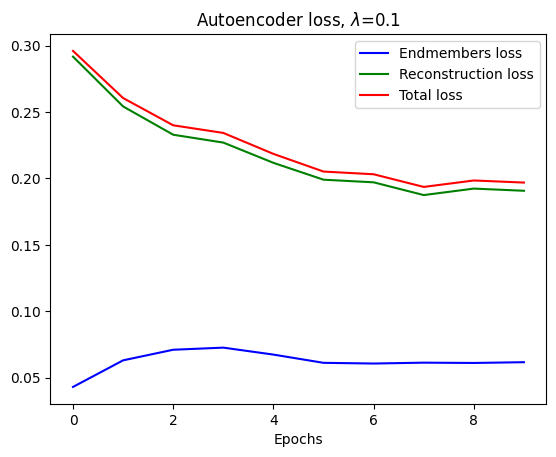

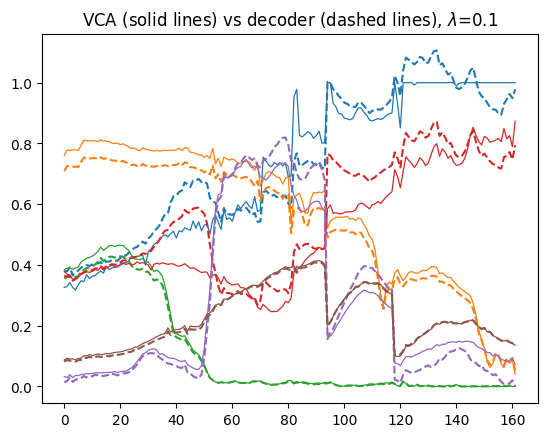

In [133]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]

lamb = 0.1

encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=VCA_endmembers.clone().T + torch.randn(R, B)*1e-3, freeze=False)

ae = AutoEncoder(encoder, decoder)

sad = AngleDistanceLoss()
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))


epochs = 10
mse_vca = []
losses_vca = []
losses_rec = []
losses = []

for e in tqdm(range(epochs)):
    loss_epoch = 0
    loss_vca_epoch = 0
    loss_rec_epoch = 0
    for b in range(len(batches)):
        opti.zero_grad()

        # Regularization w.r.t VCA endmembers
        loss_vca = sad(ae.decoder.W, VCA_endmembers.T)
        loss_vca_epoch += loss_vca.detach().cpu().numpy()
        loss_vca = lamb * loss_vca
        loss_vca.backward()
        decoder.W.grad[decoder.W.grad.isnan()] = 0
        
        # Train the reconstruction
        reconstruct = ae(batches[b])[1]
        loss_rec = sad(reconstruct, batches[b]) 
        loss_rec_epoch += loss_rec.detach().cpu().numpy()
        loss_rec.backward()
        
        if torch.any(reconstruct.isnan()):
            print("reconstruct", e, b, "nan")
            break

        
        if torch.any(loss_rec.isnan()):
            print("loss_rec", e, b, "nan")
            break
        if torch.any(loss_vca.isnan()):
            print("loss_vca", e, b, "nan")
            print(torch.any(torch.norm(ae.decoder.W, dim=0)==0), torch.any(torch.norm(ae.decoder.W, dim=0)==0))
            print(torch.any(torch.norm(VCA_endmembers, dim=1)==0), torch.any(torch.norm(VCA_endmembers, dim=1)==0))
            print(nn.CosineSimilarity(dim=1)(ae.decoder.W, VCA_endmembers.T)-1)
            print(torch.arccos(nn.CosineSimilarity(dim=1)(ae.decoder.W, VCA_endmembers.T)))
            print(torch.arccos(nn.CosineSimilarity(dim=1)(ae.decoder.W, VCA_endmembers.T)).mean())
            break

        
        for name, params in ae.named_parameters():
            if params.grad is not None and torch.any(params.grad.isnan()):
                print(e, b, "nan", name)

        opti.step()
        ae.projection()

        loss = loss_rec.detach().cpu().numpy() + loss_vca.detach().cpu().numpy()
        loss_epoch += loss
        
    losses_vca.append(loss_vca_epoch / len(batches))
    losses_rec.append(loss_rec_epoch / len(batches))
    losses.append(loss_epoch / len(batches))
    mse_vca.append(np.linalg.norm(decoder.W.detach() - VCA_endmembers.T))

print("Final loss", loss)
#plt.plot(mse_vca, label="MSE VCA", color="blue", linestyle='--')
plt.plot(losses_vca, label="Endmembers loss", color="blue")
plt.plot(losses_rec, label="Reconstruction loss", color="green")
plt.plot(losses, label="Total loss", color="red")
plt.legend()
plt.xlabel("Epochs")
plt.title("Autoencoder loss, $\lambda$="+str(lamb))
plt.show()

ref_endmembers = VCA_endmembers.detach().numpy()
dec_endmembers = decoder.W.detach().numpy().T

for i in range(R):
    plt.plot(ref_endmembers[:,i], color=plt.cm.tab10(i), linewidth=0.9)
    plt.plot(dec_endmembers[:,i], color=plt.cm.tab10(i), linestyle="--")
    #plt.plot(, label="Endmembers of the decoder", linestyle="--", linewidth=2)
plt.title("VCA (solid lines) vs decoder (dashed lines), $\lambda$="+str(lamb))
plt.show()

## Train with adversarial regularization



In [1]:
B = VCA_endmembers.shape[0]
R = VCA_endmembers.shape[1]

encoder = Encoder(B=B, R=R)
decoder = Decoder(B=B, R=R, init_endmembers=torch.tensor(VCA_endmembers.T, dtype=torch.float), freeze=False)
discriminator = Discriminator(B=B, R=R)

ae = AutoEncoder(encoder, decoder)

mse = nn.MSELoss()
sad = AngleDistanceLoss()
bceLogits = nn.BCEWithLogitsLoss()

lamb_VCA = 0.1
lamb_gen = 0.0#1

# Optimizer for autoencoder
opti = torch.optim.Adam(ae.parameters(), lr=1e-3, betas=(0.9, 0.99))

# Optimizer for discriminator
opti_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.9, 0.99))

epochs = 5
losses_SAD = []
losses_VCA = []
losses_G = []
losses_D = []
#losses = []


for e in tqdm(range(epochs)):
    weight_gen = 1 - np.exp(-0.1-0.1*e**2)
    loss_SAD_epoch = 0
    loss_VCA_epoch = 0
    loss_G_epoch = 0
    #loss_epoch = 0
    loss_D_epoch = 0

    for b in range(len(batches)):
        opti.zero_grad()

        # Regularization w.r.t VCA endmembers
        loss_VCA = sad(ae.decoder.W, VCA_endmembers.T)
        loss_vca_epoch += loss_vca.detach().cpu().numpy()
        loss_VCA = lamb_VCA * loss_VCA
        loss_VCA.backward()
        ae.decoder.W.grad[ae.decoder.W.grad.isnan()] = 0
        
        # Train the reconstruction
        embeddings, reconstruct = ae(batches[b])
        loss_SAD = sad(reconstruct, batches[b]) 
        loss_SAD_epoch += loss_SAD.detach().cpu().numpy()
        loss_SAD.backward()
        
        opti.step()
        ae.projection()

        opti.zero_grad()
        
        # Regularization using the discriminator
        embeddings, reconstruct = ae(batches[b])
        pred = discriminator(embeddings)
        loss_G = -lamb_gen*bceLogits(pred, torch.zeros((batch_size, 1), dtype=torch.float))
        loss_G.backward()
        opti.step()
        ae.projection()

        # Train the discriminator
        opti_D.zero_grad()
        embeddings, reconstruct = ae(batches[b])
        pred = discriminator(embeddings)
        
        # Generate positive samples:
        pos_samples = means[b] + torch.randn(batch_size, R) @ sqrt_covariances[b].T 
        pos_pred = discriminator(pos_samples)
        neg_pred = discriminator(embeddings.detach())

        loss_D_pos = bceLogits(pos_pred, torch.ones((batch_size, 1), dtype=torch.float)) 
        loss_D_neg = bceLogits(neg_pred, torch.zeros((batch_size, 1), dtype=torch.float))
        loss_D = loss_D_pos + loss_D_neg
        loss_D.backward()
        opti_D.step()
        

        loss_D_epoch += loss_D.detach().numpy()
        loss_SAD_epoch += loss_SAD.detach().numpy()
        loss_VCA_epoch += loss_vca.detach().numpy()
        loss_G_epoch += loss_G.detach().numpy() / weight_gen       

        

    losses_D.append(loss_D_epoch / len(batches))
    losses_SAD.append(loss_SAD_epoch / len(batches))
    losses_VCA.append(loss_VCA_epoch / len(batches))
    losses_G.append(loss_G_epoch / len(batches))


#print("Final loss", loss)
plt.plot(losses_SAD, label="SAD", color="red")
plt.plot(losses_VCA, label="VCA", color="green")
plt.plot(losses_D, label="Discriminator", color="black")
plt.plot(losses_G, label="Generator", color="blue")
plt.legend()
plt.title("Losses")
plt.show()

NameError: name 'VCA_endmembers' is not defined

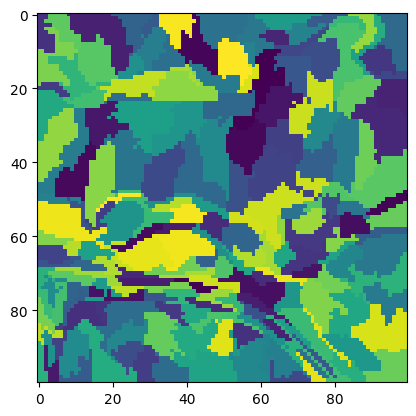

In [13]:
plt.imshow(np.load("../data/jasper/jasper_200_seg.npy"))
plt.show()

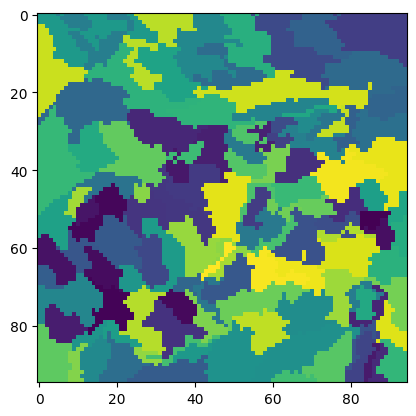

In [12]:
plt.imshow(np.load("../data/samson/samson_125_seg.npy"))
plt.show()

In [4]:
help(np.load)

Help on function load in module numpy:

load(file, mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII', *, max_header_size=10000)
    Load arrays or pickled objects from ``.npy``, ``.npz`` or pickled files.
    
    .. warning:: Loading files that contain object arrays uses the ``pickle``
                 module, which is not secure against erroneous or maliciously
                 constructed data. Consider passing ``allow_pickle=False`` to
                 load data that is known not to contain object arrays for the
                 safer handling of untrusted sources.
    
    Parameters
    ----------
    file : file-like object, string, or pathlib.Path
        The file to read. File-like objects must support the
        ``seek()`` and ``read()`` methods and must always
        be opened in binary mode.  Pickled files require that the
        file-like object support the ``readline()`` method as well.
    mmap_mode : {None, 'r+', 'r', 'w+', 'c'}, optional
       